In [ ]:
import os
import shutil, pathlib, fnmatch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from zmq.constants import THREAD_AFFINITY_CPU_ADD
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [ ]:
!unzip '/data/brazilian_coffee_dataset.zip'

In [ ]:
#Fixes the fold layout of the data, puts all of the images together
image1 = []
image2 = []
image3 = []
image4 = []
image5 = []
folder_dir = '/content/brazilian_coffee_scenes/fold1'
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image1.append(images)
folder_dir = '/content/brazilian_coffee_scenes/fold2'
for images2 in os.listdir(folder_dir):
    if (images2.endswith(".jpg")):
        image2.append(images2)
folder_dir = '/content/brazilian_coffee_scenes/fold3'
for images3 in os.listdir(folder_dir):
    if (images3.endswith(".jpg")):
        image3.append(images3)
folder_dir = '/content/brazilian_coffee_scenes/fold4'
for images4 in os.listdir(folder_dir):
    if (images4.endswith(".jpg")):
        image4.append(images4)
folder_dir = '/content/brazilian_coffee_scenes/fold5'
for images5 in os.listdir(folder_dir):
    if (images5.endswith(".jpg")):
        image5.append(images5)
all_images = image1 + image2 + image3 + image4 + image5

In [ ]:
#Seperates label from the name of the image
os.chdir('/content/brazilian_coffee_scenes')
fold1file = open("fold1.txt")
fold1content = fold1file.read()
fold1split = fold1content.split()
labels1 = []
count = 0
fold2file = open("fold2.txt")
fold2content = fold2file.read()
fold2split = fold2content.split()
labels2 = []
fold3file = open("fold3.txt")
fold3content = fold3file.read()
fold3split = fold3content.split()
labels3 = []
fold4file = open("fold4.txt")
fold4content = fold4file.read()
fold4split = fold4content.split()
labels4 = []
fold5file = open("fold5.txt")
fold5content = fold5file.read()
fold5split = fold5content.split()
labels5 = []
for label in fold1split:
  labels1.append(label.split('.',1))
for label in fold2split:
  labels2.append(label.split('.',1))
for label in fold3split:
  labels3.append(label.split('.',1))
for label in fold4split:
  labels4.append(label.split('.',1))
for label in fold5split:
  labels5.append(label.split('.',1))
all_labels = labels1 + labels2 + labels3 + labels4 + labels5
all_labels = sorted(all_labels, key=lambda x: x[1])
noncoffee = []
coffee = []
for pair in all_labels:
  if (pair[0] == "noncoffee"):
    noncoffee.append(pair[1] + ".jpg")
  elif (pair[0] == "coffee"):
    coffee.append(pair[1] + ".jpg")

['noncoffee', 'arceburgo.T1024.B1088.L2624.R2688']
montesanto.T3456.B3520.L11712.R11776.jpg


In [ ]:
#For each fold, goes through and renames images with their classification label
collection = "/content/brazilian_coffee_scenes/fold1"
for i, filename in enumerate(os.listdir(collection)):
  if(filename in coffee):
    os.rename("/content/brazilian_coffee_scenes/fold1/" + filename, "coffee" + filename)
  elif(filename in noncoffee):
    os.rename("/content/brazilian_coffee_scenes/fold1/" + filename, "non" + filename)

In [ ]:
collection = "/content/brazilian_coffee_scenes/fold2"
for i, filename in enumerate(os.listdir(collection)):
  if(filename in coffee):
    os.rename("/content/brazilian_coffee_scenes/fold2/" + filename, "coffee" + filename)
  elif(filename in noncoffee):
    os.rename("/content/brazilian_coffee_scenes/fold2/" + filename, "non" + filename)

In [ ]:
collection = "/content/brazilian_coffee_scenes/fold3"
for i, filename in enumerate(os.listdir(collection)):
  if(filename in coffee):
    os.rename("/content/brazilian_coffee_scenes/fold3/" + filename, "coffee" + filename)
  elif(filename in noncoffee):
    os.rename("/content/brazilian_coffee_scenes/fold3/" + filename, "non" + filename)

In [ ]:

collection = "/content/brazilian_coffee_scenes/fold4"
for i, filename in enumerate(os.listdir(collection)):
  if(filename in coffee):
    os.rename("/content/brazilian_coffee_scenes/fold4/" + filename, "coffee" + filename)
  elif(filename in noncoffee):
    os.rename("/content/brazilian_coffee_scenes/fold4/" + filename, "non" + filename)

In [ ]:
collection = "/content/brazilian_coffee_scenes/fold5"
for i, filename in enumerate(os.listdir(collection)):
  if(filename in coffee):
    os.rename("/content/brazilian_coffee_scenes/fold5/" + filename, "coffee" + filename)
  elif(filename in noncoffee):
    os.rename("/content/brazilian_coffee_scenes/fold5/" + filename, "non" + filename)


In [ ]:
#Creating NonCoffee and Coffee folders of the appropriate images
coffee_dir = os.path.join("/content", "coffee")
noncoffee_dir = os.path.join("/content", "test")
os.makedirs(coffee_dir, exist_ok=True)
os.makedirs(noncoffee_dir, exist_ok=True)
collection = "/content/brazilian_coffee_scenes"
for file in enumerate(os.listdir(collection)):
  if "coffee" in file[1]:
    shutil.move(os.path.join(collection, file[1]),os.path.join("/content/Coffee", file[1]))
  elif "non" in file[1]:
    shutil.move(os.path.join(collection, file[1]),os.path.join("/content/NonCoffee", file[1]))

In [ ]:
#Splitting into test/train
#Muaz created test and train definition
def train_test_split_folder(base_dir, output_dir, test_size=0.2):
    #Creating train and test folders
    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    # List classes based on subdirectory names
    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for cls in classes:
        # Create output directories for this class
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        # List all jpg images in this class
        images = [f for f in os.listdir(os.path.join(base_dir, cls)) if f.endswith(('.jpg'))]
        # Shuffle the images
        random.shuffle(images)
        # Split point
        split_point = int(len(images) * (1 - test_size))
        # Split the images into train and test sets
        train_images = images[:split_point]
        test_images = images[split_point:]
        # Move the images
        for img in train_images:
            shutil.copy(os.path.join(base_dir, cls, img), os.path.join(train_dir, cls, img))
        for img in test_images:
            shutil.copy(os.path.join(base_dir, cls, img), os.path.join(test_dir, cls, img))
        print(f"Processed {cls} - {len(train_images)} training, {len(test_images)} test")

train_test_split_folder("/content", "/content", test_size=0.2)

Processed NonCoffee - 1150 training, 288 test
Processed Coffee - 1150 training, 288 test


Number of Images:  2300
Number of Labels:  2300


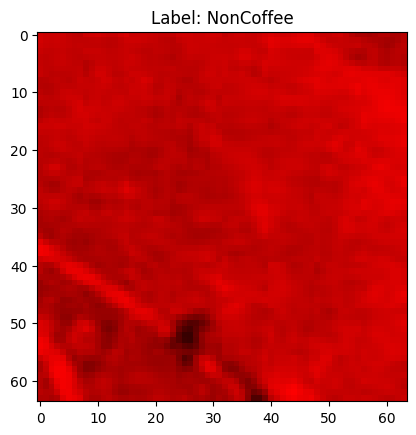

In [ ]:
#This code was changed for each experimental condition, explanation of how to do this is in the ReadMe
train_dir = '/content/train'

train_images = []
train_labels = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)

    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        image = Image.open(image_path)
        image_array = np.array(image)
        #image_array[:,:,0] = np.zeros((64,64))
        #image_array[:,:,1] = np.zeros((64,64))
        #image_array[:,:,2] = np.zeros((64,64))
        train_images.append(image_array)
        train_labels.append(label)

# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the length of images and labels
print('Number of Images: ', len(train_images))
print('Number of Labels: ', len(train_labels))

# Visualize the first image
plt.imshow(train_images[0])
plt.title(f'Label: {train_labels[0]}')
plt.show()

Number of Images:  576
Number of Labels:  576


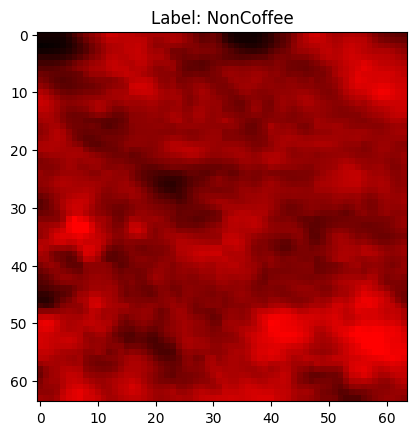

In [ ]:
#This code (modifying the test dataset) was also modified for each experimental condition, details are in the ReadMe
test_dir = '/content/test'

# Initialize empty lists to store images and labels
test_images = []
test_labels = []

# Iterate through each subfolder
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)

    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        image = Image.open(image_path)
        image_array = np.array(image)
        #image_array[:,:,0] = np.zeros((64,64))
        #image_array[:,:,1] = np.zeros((64,64))
        #image_array[:,:,2] = np.zeros((64,64))
        test_images.append(image_array)
        test_labels.append(label)

# Convert the lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print the length of images and labels
print('Number of Images: ', len(test_images))
print('Number of Labels: ', len(test_labels))

# Visualize the first image
plt.imshow(test_images[0])
plt.title(f'Label: {test_labels[0]}')
plt.show()

In [ ]:
x_train, y_train = train['images'], train['labels']
X_test, y_test = test['images'], test['labels']

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        if self.transform:
            x = self.transform(x)
        return x, self.y[index]

In [ ]:
# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# DataLoader for training and testing sets
batch_size = 32
train_dataset = CustomDataset(x_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(X_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# List unique labels
unique_labels = list(set(list(y_train)))

# Create a label mapping from string labels to integers
#like key-value pair in java
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Define a custom function to convert string labels to integers
def labels_to_integers(labels, label_mapping):
    return [label_mapping[label] for label in labels]

In [ ]:
# Define transformation of each image
splits_dir = os.path.join("/content", "Train_Test_Splits/")
os.makedirs(splits_dir, exist_ok=True)
# Make Train_Test_Splits folder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load EuroSAT dataset
#more efficient than prev.
data_dir = splits_dir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'test']}

FileNotFoundError: ignored

In [ ]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
num_classes = 2

# Modify the final fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
#define device var
#cuda = gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [ ]:
#define training loop with a for loop
# Training loop
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = corrects.double() / len(image_datasets[phase])
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
# Train the model
train_model(model, dataloaders, loss_fn, optimizer, num_epochs=10)

train Loss: 0.4801 Acc: 0.7991
test Loss: 0.3578 Acc: 0.8316
train Loss: 0.2615 Acc: 0.8961
test Loss: 0.2641 Acc: 0.8872
train Loss: 0.1816 Acc: 0.9339
test Loss: 0.2388 Acc: 0.8941
train Loss: 0.1311 Acc: 0.9509
test Loss: 0.2094 Acc: 0.9201
train Loss: 0.0869 Acc: 0.9743
test Loss: 0.2213 Acc: 0.9184
train Loss: 0.0505 Acc: 0.9870
test Loss: 0.2116 Acc: 0.9201
train Loss: 0.0355 Acc: 0.9948
test Loss: 0.2188 Acc: 0.9132
train Loss: 0.0262 Acc: 0.9970
test Loss: 0.2433 Acc: 0.9167
train Loss: 0.0146 Acc: 1.0000
test Loss: 0.2555 Acc: 0.9115
train Loss: 0.0156 Acc: 0.9987
test Loss: 0.2475 Acc: 0.9149


In [ ]:
#model evaluation
# Evaluate the model on the test set
model.eval()
true_labels = []
predictions = []

#make a list of true lables & predictions by using test data set
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        #outputs throws out probability for each class
        _, preds = torch.max(outputs, 1)
        #torch.max = most probable class
        #_ = probability for each class
        #preds variable means the class

    #extend means append labels to true labels, bc true labels is the answer
    #append preds to predictions list & then compare to test accuracy
    #we use cpu here to restore them to cpu enviornment, GPU is a diff enviornement
    #wan to view labels & preds as numpy arrayas
    true_labels.extend(labels.cpu().numpy())
    predictions.extend(preds.cpu().numpy())

# Get a test accuracy
#counts how many true labels = prediction labels, * 100 for percentage value
test_acc = np.sum(np.array(true_labels) == np.array(predictions)) / len(true_labels)
test_acc_percent = test_acc * 100
print(f'Test Accuracy: {test_acc_percent:.2f}%')

Test Accuracy: 89.76%


In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#divides each number by sum of its label to make it a number > 0, < 1


#rest of code is for plotting:
# Get the class labels
num_classes = 2
class_labels = [str(i) for i in range(num_classes)]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.7)
ax = sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='YlOrBr',
                 xticklabels=class_labels,
                 yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Using ResNet-50 model pretrained on ImageNet on Brazilian Coffee data without Near Infrared)')

# Rotate x-axis tick labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add a black border around the confusion matrix
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')

plt.show()